In [3]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from datetime import datetime
from tensorboard import program
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
# from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
# from losses import mse_split_loss, radius, kl_loss
# from functions import make_mse_loss_numpy, save_model
from sklearn.metrics import roc_curve, auc


# from data_preprocessing import prepare_data
# from model import build_AE, build_VAE, build_QVAE


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

import tensorflow_model_optimization as tfmot
tsk = tfmot.sparsity.keras

from qkeras.quantizers import quantized_bits

from keras.utils import tf_utils

quantize=False

In [5]:
input_hardqcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-ZB-h5-extended-v2/ZB_preprocessed.h5"
input_bsm = "/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2-120X/BSM_preprocessed.h5"
events=500000
norm = 'std'
output = {}


with h5py.File(input_qcd, 'r') as h5f:
    output['ZeroBias'] = {}
    
    data = np.array(h5f['full_data_cyl'][:events], dtype=np.float16)
    ET = np.array(h5f['ET'][:events], dtype=np.float16)
    L1bit = np.array(h5f['L1bit'][:events], dtype=np.int8)

    #mask saturated ET
    mask_ET = ET<2047.5
    ET = ET[mask_ET]
    data = data[mask_ET]
    L1bit = L1bit[mask_ET]
    
    #mask saturated PT
    mask_0  = data[:,0,0]<2047.5
    mask_1_9  = data[:,1:9,0]<255.5
    mask_9_20  = data[:,9:20,0]<1023.5
    mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
    data = data*mask[:,:,np.newaxis]

    pt = np.copy(data[:,:,0])
    eta = np.copy(data[:,:,1])
    phi = np.copy(data[:,:,2])
    
    data[:,:,0] = pt*np.cos(phi)
    data[:,:,1] = pt*np.sin(phi)
    data[:,:,2] = pt*np.sinh(eta)
    data_target = np.copy(data)

    del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask

    
    # print(h5f.keys())

    if(norm=='ET'):
        data_target[:,:,:] = data[:,:,:]/ET[:,None,None]
        std_xy = (np.std(data_target[:,:,0])+np.std(data_target[:,:,1]))/2
        std_z = np.std(data_target[:,:,2])
        data_target[:,:,2] = data_target[:,:,2]*(std_xy/std_z)
    elif(norm=='std'):
        mean_qcd = np.mean(data_target, axis=0)
        std_qcd = np.std(data_target, axis=0)
        data_target = (data_target[:,:,:] - mean_qcd[None,:,:])/std_qcd[None,:,:]

        # mean_qcd = np.array([np.mean(data_target[:,:,0]),np.mean(data_target[:,:,1]),np.mean(data_target[:,1:20,2])])
        # std_qcd = np.array([np.std(data_target[:,:,0]),np.std(data_target[:,:,1]),np.std(data_target[:,1:20,2])])
        # data_target[:,:,0] = (data_target[:,:,0]-mean_qcd[0])/std_qcd[0]
        # data_target[:,:,1] = (data_target[:,:,1]-mean_qcd[1])/std_qcd[1]
        # data_target[:,:,2] = (data_target[:,:,2]-mean_qcd[2])/std_qcd[2] 
        data_target[:,0,2] = 0
    else:
        data_target[:,0,:] = data[:,0,:]/2048
        data_target[:,1:9,:] = data[:,1:9,:]/256
        data_target[:,9:20,:] = data[:,9:20,:]/1024
        

    X_train, output['ZeroBias']['data'], Y_train, output['ZeroBias']['target'], _ , output['ZeroBias']['ET'], _ ,output['ZeroBias']['L1bit'] =  train_test_split( data, data_target, ET,L1bit, test_size=0.5)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2])

del data, data_target, ET, L1bit


with h5py.File(input_hardqcd, 'r') as h5f:
    output['QCD'] = {}
    
    data = np.array(h5f['full_data_cyl'][:events], dtype=np.float16)
    ET = np.array(h5f['ET'][:events], dtype=np.float16)
    L1bit = np.array(h5f['L1bit'][:events], dtype=np.int8)

    #mask saturated ET
    mask_ET = ET<2047.5
    ET = ET[mask_ET]
    data = data[mask_ET]
    L1bit = L1bit[mask_ET]
    
    #mask saturated PT
    mask_0  = data[:,0,0]<2047.5
    mask_1_9  = data[:,1:9,0]<255.5
    mask_9_20  = data[:,9:20,0]<1023.5
    mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
    data = data*mask[:,:,np.newaxis]

    pt = np.copy(data[:,:,0])
    eta = np.copy(data[:,:,1])
    phi = np.copy(data[:,:,2])
    
    data[:,:,0] = pt*np.cos(phi)
    data[:,:,1] = pt*np.sin(phi)
    data[:,:,2] = pt*np.sinh(eta)
    data_target = np.copy(data)

    del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask

    
    # print(h5f.keys())

    if(norm=='ET'):
        data_target[:,:,:] = data[:,:,:]/ET[:,None,None]
        data_target[:,:,2] = data_target[:,:,2]*(std_xy/std_z)
    elif(norm=='std'):

        data_target = (data_target[:,:,:] - mean_qcd[None,:,:])/std_qcd[None,:,:]
        # data_target[:,:,0] = (data_target[:,:,0]-mean_qcd[0])/std_qcd[0]
        # data_target[:,:,1] = (data_target[:,:,1]-mean_qcd[1])/std_qcd[1]
        # data_target[:,:,2] = (data_target[:,:,2]-mean_qcd[2])/std_qcd[2] 
        data_target[:,0,2] = 0
    else:
        data_target[:,0,:] = data[:,0,:]/2048
        data_target[:,1:9,:] = data[:,1:9,:]/256
        data_target[:,9:20,:] = data[:,9:20,:]/1024
        

    output['QCD']['data'], output['QCD']['target'], output['QCD']['ET'],output['QCD']['L1bit'] =   data, data_target, ET,L1bit

del data, data_target, ET, L1bit

with h5py.File(input_bsm,'r') as h5f2:
    for key in h5f2.keys():
        if('TT' not in key[:2]) and ('haa4b_ma15_powheg' not in key) and ('GluGluToHHTo4B_cHHH1' not in key): continue
        if len(h5f2[key].shape) < 3: continue
        print(key)
        output[str(key)] = {}
        output[str(key)]['data'] = np.array(h5f2[str(key)][:events,:,:],dtype=np.float16)
        output[str(key)]['ET'] = np.array(h5f2[str(key)+'_ET'][:events],dtype=np.float16)
        output[str(key)]['L1bit'] = np.array(h5f2[str(key)+'_l1bit'][:events],dtype=np.int8)

        #mask saturated ET
        mask_ET = output[str(key)]['ET']<2047.5
        output[str(key)]['ET'] = output[str(key)]['ET'][mask_ET]
        output[str(key)]['data'] = output[str(key)]['data'][mask_ET]
        output[str(key)]['L1bit'] = output[str(key)]['L1bit'][mask_ET]
        
        #mask saturated PT
        mask_0  = output[str(key)]['data'][:,0,0]<2047.5
        mask_1_9  = output[str(key)]['data'][:,1:9,0]<255.5
        mask_9_20  = output[str(key)]['data'][:,9:20,0]<1023.5
        mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
        output[str(key)]['data'] = output[str(key)]['data']*mask[:,:,np.newaxis]

        pt = np.copy(output[str(key)]['data'][:,:,0])
        eta = np.copy(output[str(key)]['data'][:,:,1])
        phi = np.copy(output[str(key)]['data'][:,:,2])
        
        output[str(key)]['data'][:,:,0] = pt*np.cos(phi)
        output[str(key)]['data'][:,:,1] = pt*np.sin(phi)
        output[str(key)]['data'][:,:,2] = pt*np.sinh(eta)

        del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask


        output[str(key)]['target'] = np.copy(output[str(key)]['data'])
        if(norm=='ET'):
            output[str(key)]['target'] = output[str(key)]['data']/output[str(key)]['ET'][:,None,None]
            output[str(key)]['target'][:,:,2] = output[str(key)]['target'][:,:,2]*(std_xy/std_z)
        elif(norm=='std'):
            output[str(key)]['target'] = (output[str(key)]['target'] - mean_qcd[None,:,:])/std_qcd[None,:,:]
            # output[str(key)]['target'][:,:,0]= (output[str(key)]['data'][:,:,0]-mean_qcd[0])/std_qcd[0]
            # output[str(key)]['target'][:,:,1]= (output[str(key)]['data'][:,:,1]-mean_qcd[1])/std_qcd[1]
            # output[str(key)]['target'][:,:,2]= (output[str(key)]['data'][:,:,2]-mean_qcd[2])/std_qcd[2]
            output[str(key)]['target'][:,0,2] = 0
        elif(norm=='max_PT'):
            output[str(key)]['target'][:,0,:] = output[str(key)]['data'][:,0,:]/2048
            output[str(key)]['target'][:,1:9,:] = output[str(key)]['data'][:,1:9,:]/256
            output[str(key)]['target'][:,9:20,:] = output[str(key)]['data'][:,9:20,:]/1024

        

GluGluToHHTo4B_cHHH1
TT
haa4b_ma15_powheg


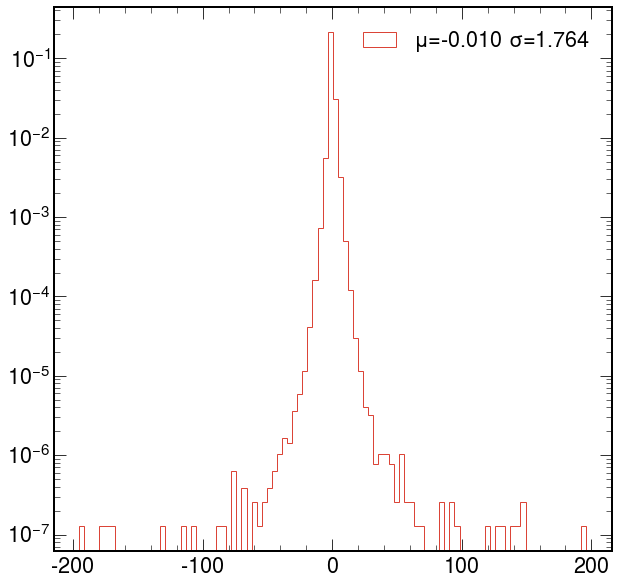

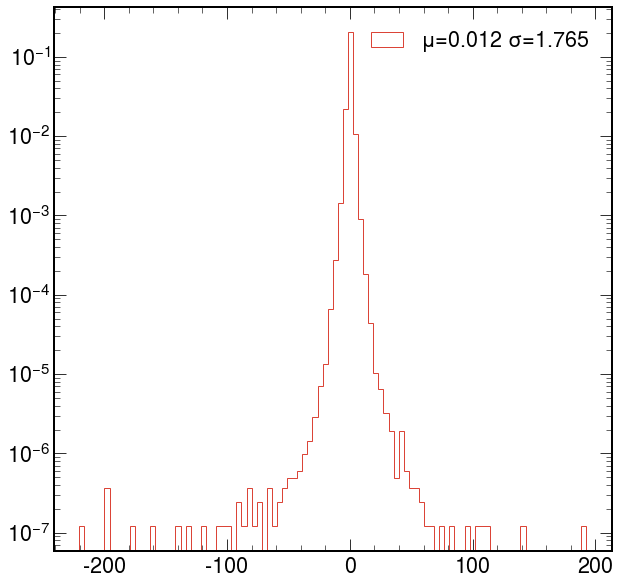

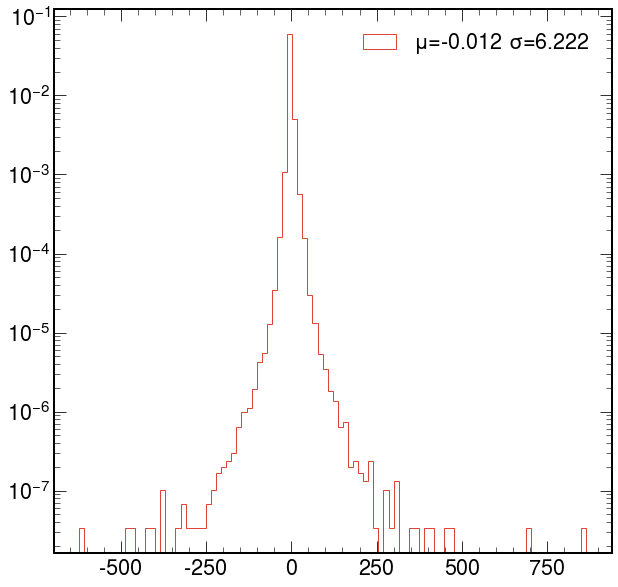

In [6]:

_=plt.hist(output['ZeroBias']['data'][:,1:9,0].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['data'][:,1:9,0]),np.std(output['ZeroBias']['data'][:,1:9,0])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()

_=plt.hist(output['ZeroBias']['data'][:,1:9,1].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['data'][:,1:9,1]),np.std(output['ZeroBias']['data'][:,1:9,1])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()

_=plt.hist(output['ZeroBias']['data'][:,1:9,2].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['data'][:,1:9,2]),np.std(output['ZeroBias']['data'][:,1:9,2])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()


In [ ]:

_=plt.hist(output['ZeroBias']['target'][:,:,0].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['target'][:,:,0]),np.std(output['ZeroBias']['target'][:,:,0])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()

_=plt.hist(output['ZeroBias']['target'][:,:,1].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['target'][:,:,1]),np.std(output['ZeroBias']['target'][:,:,1])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()

_=plt.hist(output['ZeroBias']['target'][:,:,2].flatten(),bins=100,label=r'$\mu$={:0.3f} $\sigma$={:0.3f}'.format(np.mean(output['ZeroBias']['target'][:,:,2]),np.std(output['ZeroBias']['target'][:,:,2])),histtype='step',density=True)
plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
bins = np.linspace(-1024,1024,100)
for key in output.keys():
    _=plt.hist(output[key]['data'][:,:,0].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['data'][:,:,0]),np.std(output[key]['data'][:,:,0])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$p_x$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()

for key in output.keys():
    _=plt.hist(output[key]['data'][:,:,1].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['data'][:,:,1]),np.std(output[key]['data'][:,:,1])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$p_y$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()


bins = np.linspace(-7500,7500,100)
for key in output.keys():
    _=plt.hist(output[key]['data'][:,:,2].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['data'][:,:,2]),np.std(output[key]['data'][:,:,2])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$p_z$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()

In [ ]:
bins = np.linspace(-1,1,100)
for key in output.keys():
    _=plt.hist(output[key]['target'][:,:,0].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['target'][:,:,0]),np.std(output[key]['target'][:,:,0])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$\hat{p}_x$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()

for key in output.keys():
    _=plt.hist(output[key]['target'][:,:,1].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['target'][:,:,1]),np.std(output[key]['target'][:,:,1])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$\hat{p}_y$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()

for key in output.keys():
    _=plt.hist(output[key]['target'][:,:,2].flatten(),bins=bins,label=r'{} $\mu$={:0.3f} $\sigma$={:0.3f}'.format(key.split('_')[0],np.mean(output[key]['target'][:,:,2]),np.std(output[key]['target'][:,:,2])),histtype='step',density=True)
plt.yscale('log')
plt.xlabel(r'$\hat{p}_z$')
plt.legend(fontsize='x-small',loc='upper left')
plt.show()

In [7]:
reco_scale = 1000
beta = 0.8

def mse_loss(inputs, outputs):
    # remove last dimension
    inputs = tf.reshape(inputs, (tf.shape(inputs)[0],19,3))
    outputs = tf.reshape(outputs, (tf.shape(outputs)[0],19,3))
    
    mask0 = tf.math.not_equal(inputs[:,:,0],0)
    mask1 = tf.math.not_equal(inputs[:,:,1],0)
    mask2 = tf.math.not_equal(inputs[:,:,2],0)
    mask = tf.math.logical_and(mask0, mask1)
    mask = tf.math.logical_and(mask, mask2)
    # tf.print(mask)
    mask = tf.cast(mask, tf.float32)
    mask = tf.reshape(mask, (tf.shape(mask)[0],19,1))

    # remove zero entries
    loss = reco_scale*tf.reduce_mean(tf.square(inputs[:,:,:]-outputs[:,:,:])*mask)
    return loss

def mse_loss_numpy(inputs, outputs):
    # remove last dimension
    inputs = np.reshape(inputs, (inputs.shape[0],19,3))
    outputs = np.reshape(outputs, (outputs.shape[0],19,3))
    
    mask0 = inputs[:,:,0]!=0
    mask1 = inputs[:,:,1]!=0
    mask2 = inputs[:,:,2]!=0
    mask = (mask0 + mask1 + mask2)*1
    mask = np.reshape(mask, (mask.shape[0],19,1))
    inputs = inputs*mask
    outputs = outputs*mask

    # remove zero entries
    loss = np.mean(np.square(inputs.reshape(inputs.shape[0],57)-outputs.reshape(outputs.shape[0],57)),axis=1)
    return loss

def radius(mean, logvar):
    sigma = np.sqrt(np.exp(logvar))
    radius = mean*mean/sigma/sigma
    return np.sum(radius, axis=-1)

def kl_loss(mu, logvar, beta=None):
    kl_loss = 1 + logvar - np.square(mu) - np.exp(logvar)
    kl_loss = np.mean(kl_loss, axis=-1) # mean over latent dimensions
    kl_loss *= -0.5
    if beta!=None: return beta*kl_loss
    else: return kl_loss


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

mse = tf.keras.losses.MeanSquaredError()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="reconstruction_val_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="kl_val_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_val_loss_tracker,
            self.reconstruction_val_loss_tracker,
            self.kl_val_loss_tracker,
        ]

    
    def train_step(self, data):
        data_in, target = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data_in)
            reconstruction = self.decoder(z)
            reconstruction_loss = (1-beta)*mse_loss(target, reconstruction) #one value
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        # tf.print(reconstruction_loss,kl_loss)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
   
    def test_step(self, data):
        data_in, target = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data_in)
            reconstruction = self.decoder(z)
            reconstruction_loss = (1-beta)*mse_loss(target, reconstruction) #one value
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result(),
        }
    
    
    def predict(self, data_in, batch_size=32, return_latent=False):
        # print(data_in)
        data_batch = tf.data.Dataset.from_tensor_slices((data_in))
        output, z_mean, z_logvar = [],[],[]
        for data in data_batch.batch(batch_size):
            # print(data.shape)
            z_mean_, z_logvar_, z_ = self.encoder(data)
            output_ = self.decoder(z_)
            output.append(output_)
            z_mean.append(z_mean_)
            z_logvar.append(z_logvar_)
        # print(len(output),len(z_mean),len(z_logvar))
        # print(output[0])
        output = tf.concat(output,0)
        z_mean = tf.concat(z_mean,0)
        z_logvar = tf.concat(z_logvar,0)
    
        if(return_latent):
            return tf_utils.sync_to_numpy_or_python_type(output), tf_utils.sync_to_numpy_or_python_type(z_mean), tf_utils.sync_to_numpy_or_python_type(z_logvar)
        else:
            return tf_utils.sync_to_numpy_or_python_type(output)
    


In [10]:
latent_dim=4
input_shape=57
inputs = keras.Input(shape=(input_shape,))
x = layers.Dense(32,kernel_initializer='lecun_uniform', activation='relu')(inputs)
# x = layers.BatchNormalization()(x)
x = layers.Dense(32,kernel_initializer='lecun_uniform', activation='relu')(x)
# x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim,kernel_initializer='zeros')(x)
z_logvar = layers.Dense(latent_dim,kernel_initializer='zeros')(x)
print(z_mean)
print(z_logvar)
z = Sampling()([z_mean, z_logvar])
print(z)
encoder = keras.Model(inputs, [z_mean, z_logvar, z], name="encoder")
encoder.summary()


latent_inputs = keras.Input(latent_dim,)
y = layers.Dense(16,kernel_initializer='lecun_uniform', activation='relu')(latent_inputs)
y = layers.Dense(32,kernel_initializer='lecun_uniform', activation='relu')(y)
y = layers.Dense(64,kernel_initializer='lecun_uniform', activation='relu')(y)
y = layers.Dense(128,kernel_initializer='lecun_uniform', activation='relu')(y)
# y = layers.Dense(256,kernel_initializer='lecun_uniform', activation='relu')(y)
decoded = layers.Dense(input_shape)(y)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.1, cooldown=2, min_lr=1e-6))
callbacks.append(TerminateOnNaN())
# callbacks.append(NeptuneMonitor())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=2, restore_best_weights=True))

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_20/BiasAdd:0', description="created by layer 'dense_20'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_21/BiasAdd:0', description="created by layer 'dense_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='sampling_2/add:0', description="created by layer 'sampling_2'")
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 32)           1856        ['input_5[0][0]']                
                                      

In [ ]:
history = vae.fit(Y_train, Y_train,validation_split=0.2, epochs=500, batch_size=1024, verbose=1, callbacks=callbacks)

In [ ]:
#plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
#plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['kl_loss'], label='train')
plt.plot(history.history['val_kl_loss'], label='test')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
for key in output.keys():
    Y_predict, z_mean , z_logvar = vae.predict(output[key]['target'].reshape(output[key]['target'].shape[0],57),batch_size=1024*4,return_latent=True)
    Y_predict = Y_predict.reshape(Y_predict.shape[0],19,3)
    output[key]['prediction'] = Y_predict
    output[key]['reco_loss'] = mse_loss_numpy(output[key]['target'], Y_predict)
    output[key]['kl_loss'] = kl_loss(z_mean, z_logvar)
    output[key]['radius'] = radius(z_mean, z_logvar)
    output[key]['total_loss'] = output[key]['reco_loss'] + output[key]['kl_loss']

In [ ]:
bkg_key='ZeroBias'
bins_ = np.linspace(-1,1,100)
test = output[bkg_key]['target'][:,1:9,:]
test = test.reshape(output[bkg_key]['target'].shape[0]*8,3)
mask0 = test[:,0]!=0
mask1 = test[:,1]!=0
mask2 = test[:,2]!=0
mask = mask0 + mask1 + mask2
test = test[mask]
predict = output[bkg_key]['prediction'][:,1:9,:]
predict = predict.reshape(output[bkg_key]['prediction'].shape[0]*8,3)
predict = predict[mask]
plt.hist(test.flatten(), bins=bins_, alpha=0.5, label='X_test')
plt.hist(predict.flatten(), bins=bins_, alpha=0.5, label='X_predict')
plt.xlabel('Pi (GeV)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.title('Muon, electon, and photon pt')

In [ ]:
bkg_key='ZeroBias'
bins_ = np.linspace(-1,1,100)
test = output[bkg_key]['target'][:,9:20,:]
test = test.reshape(output[bkg_key]['target'].shape[0]*10,3)
mask0 = test[:,0]!=0
mask1 = test[:,1]!=0
mask2 = test[:,2]!=0
mask = mask0 + mask1 + mask2
test = test[mask]
predict = output[bkg_key]['prediction'][:,9:20,:]
predict = predict.reshape(output[bkg_key]['prediction'].shape[0]*10,3)
predict = predict[mask]
plt.hist(test[:,0].flatten(), bins=bins_, alpha=0.5, label='X_test')
plt.hist(predict[:,0].flatten(), bins=bins_, alpha=0.5, label='X_predict')
plt.xlabel('Pi (GeV)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.title('Jet pt')

In [ ]:
min_loss,max_loss=1e5,0
min_tloss,max_tloss=1e5,0
min_r,max_r=1e5,0
min_kloss,max_kloss=1e5,0
for key in output.keys():
    if(key=='ZeroBias'): continue
    if(np.min(output[key]['reco_loss'])<min_loss): min_loss = np.min(output[key]['reco_loss'])
    if(np.mean(output[key]['reco_loss'])+10*np.std(output[key]['reco_loss'])>max_loss): max_loss = np.mean(output[key]['reco_loss'])+10*np.std(output[key]['reco_loss'])
    
    if(np.min(output[key]['total_loss'])<min_tloss): min_tloss = np.min(output[key]['total_loss'])
    if(np.mean(output[key]['total_loss'])+10*np.std(output[key]['total_loss'])>max_tloss): max_tloss = np.mean(output[key]['total_loss'])+10*np.std(output[key]['total_loss'])
    if(np.min(output[key]['radius'])<min_r): min_r = np.min(output[key]['radius'])
    if(np.mean(output[key]['radius'])+10*np.std(output[key]['radius'])>max_r): max_r = np.mean(output[key]['radius'])+10*np.std(output[key]['radius'])
    if(np.min(output[key]['kl_loss'])<min_kloss): min_kloss = np.min(output[key]['kl_loss'])
    if(np.mean(output[key]['kl_loss'])+10*np.std(output[key]['kl_loss'])>max_kloss): max_kloss = np.mean(output[key]['kl_loss'])+10*np.std(output[key]['kl_loss'])

In [ ]:
np.mean(output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])])+10*np.std(output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])])

In [ ]:
max_r = np.max(output[key]['radius'][np.isfinite(output[key]['radius'])])
# max_kloss=np.max(output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])])

In [ ]:
print(min_loss,max_loss)
print(min_tloss,max_tloss)
print(min_r,max_r)
print(min_kloss,max_kloss)

In [ ]:
tag='norm_test'
bkg_key='ZeroBias'
print("Plotting the results")
bins_=np.linspace(min_loss,1,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): plt.hist(output[key]['reco_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['reco_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Reco Loss')
plt.ylabel('Density')
plt.title('Loss distribution')

# plt.show()



bins_=np.linspace(min_tloss,160,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): plt.hist(output[key]['total_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['total_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss distribution')


bins_=np.linspace(min_r,100000,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): plt.hist(output[key]['radius'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['radius'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Radius distribution')


bins_=np.linspace(min_kloss,160,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): plt.hist(output[key]['kl_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['kl_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('KL Loss')
plt.ylabel('Density')
plt.title('KL distribution')

In [ ]:
#Make ROC curves
bkg_key='ZeroBias'
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): continue
    true_labels = np.concatenate((np.ones(output[key]['reco_loss'].shape[0]),np.zeros(output[bkg_key]['reco_loss'].shape[0])))
    pred_labels = np.concatenate((output[key]['reco_loss'],output[bkg_key]['reco_loss']))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reco Loss')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): continue
    sig = output[key]['total_loss'][np.isfinite(output[key]['total_loss'])]
    bkg = output[bkg_key]['total_loss'][np.isfinite(output[bkg_key]['total_loss'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Total Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): continue
    sig = output[key]['radius'][np.isfinite(output[key]['radius'])]
    bkg = output[bkg_key]['radius'][np.isfinite(output[bkg_key]['radius'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Radius')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key): continue
    sig = output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])]
    bkg = output[bkg_key]['kl_loss'][np.isfinite(output[bkg_key]['kl_loss'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KL Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
#Make ROC curves
bkg_key='ZeroBias'
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key or key=='QCD'): continue
    true_labels = np.concatenate((np.ones(output[key]['reco_loss'].shape[0]),np.zeros(output[bkg_key]['reco_loss'].shape[0])))
    pred_labels = np.concatenate((output[key]['reco_loss'],output[bkg_key]['reco_loss']))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    rate = fpr*11245.6*2544/(10**6)
    if('TT' in key): key_ = 'TTbar'
    if('haa' in key): key_ = 'Higgs -> 4b'
    if('HH' in key): key_ = 'SM HH -> 4b'
    plt.plot(rate, tpr, label=key_+' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 11245.6*2544/(10**6)], [0, 1], 'k--')
plt.xlim([1e-6*11245.6*2544/(10**6), 11245.6*2544/(10**6)])
plt.ylim([1e-6, 1.05])
plt.xlabel('Trigger Rate (MHz)')
plt.ylabel('Signal Efficiency')
plt.title('Reco Loss')
plt.axvline(0.005, color='red', linestyle='dashed', linewidth=1)
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key or key=='QCD'): continue
    sig = output[key]['total_loss'][np.isfinite(output[key]['total_loss'])]
    bkg = output[bkg_key]['total_loss'][np.isfinite(output[bkg_key]['total_loss'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    rate = fpr*11245.6*2544/(10**6)
    if('TT' in key): key_ = 'TTbar'
    if('haa' in key): key_ = 'Higgs -> 4b'
    if('HH' in key): key_ = 'SM HH -> 4b'
    plt.plot(rate, tpr, label=key_+' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 11245.6*2544/(10**6)], [0, 1], 'k--')
plt.xlim([1e-6*11245.6*2544/(10**6), 11245.6*2544/(10**6)])
plt.ylim([1e-6, 1.05])
plt.xlabel('Trigger Rate (MHz)')
plt.ylabel('Signal Efficiency')
plt.title('Total Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.005, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key or key=='QCD'): continue
    sig = output[key]['radius'][np.isfinite(output[key]['radius'])]
    bkg = output[bkg_key]['radius'][np.isfinite(output[bkg_key]['radius'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    rate = fpr*11245.6*2544/(10**6)
    if('TT' in key): key_ = 'TTbar'
    if('haa' in key): key_ = 'Higgs -> 4b'
    if('HH' in key): key_ = 'SM HH -> 4b'
    plt.plot(rate, tpr, label=key_+' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 11245.6*2544/(10**6)], [0, 1], 'k--')
plt.xlim([1e-6*11245.6*2544/(10**6), 11245.6*2544/(10**6)])
plt.ylim([1e-6, 1.05])
plt.xlabel('Trigger Rate (MHz)')
plt.ylabel('Signal Efficiency')
plt.title('Radius')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.005, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key==bkg_key or key=='QCD'): continue
    sig = output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])]
    bkg = output[bkg_key]['kl_loss'][np.isfinite(output[bkg_key]['kl_loss'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    rate = fpr*11245.6*2544/(10**6)
    if('TT' in key): key_ = 'TTbar'
    if('haa' in key): key_ = 'Higgs -> 4b'
    if('HH' in key): key_ = 'SM HH -> 4b'
    plt.plot(rate, tpr, label=key_+' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 11245.6*2544/(10**6)], [0, 1], 'k--')
plt.xlim([1e-6*11245.6*2544/(10**6), 11245.6*2544/(10**6)])
plt.ylim([1e-6, 1.05])
plt.xlabel('Trigger Rate (MHz)')
plt.ylabel('Signal Efficiency')
plt.title('KL Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.005, color='red', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
tag='norm_test'
print("Plotting the results")
bins_=np.linspace(min_loss,max_loss,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): plt.hist(output[key]['reco_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['reco_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Reco Loss')
plt.ylabel('Density')
plt.title('Loss distribution')

# plt.show()



bins_=np.linspace(min_tloss,max_tloss,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): plt.hist(output[key]['total_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['total_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss distribution')


bins_=np.linspace(min_r,max_r,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): plt.hist(output[key]['radius'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['radius'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Radius distribution')


bins_=np.linspace(min_kloss,max_kloss,100)
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): plt.hist(output[key]['kl_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(output[key]['kl_loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('KL Loss')
plt.ylabel('Density')
plt.title('KL distribution')

In [ ]:
#Make ROC curves
plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): continue
    true_labels = np.concatenate((np.ones(output[key]['reco_loss'].shape[0]),np.zeros(output['qcd']['reco_loss'].shape[0])))
    pred_labels = np.concatenate((output[key]['reco_loss'],output['qcd']['reco_loss']))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reco Loss')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): continue
    true_labels = np.concatenate((np.ones(output[key]['total_loss'].shape[0]),np.zeros(output['qcd']['total_loss'].shape[0])))
    pred_labels = np.concatenate((output[key]['total_loss'],output['qcd']['total_loss']))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Total Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): continue
    sig = output[key]['radius'][np.isfinite(output[key]['radius'])]
    bkg = output['qcd']['radius'][np.isfinite(output['qcd']['radius'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Radius')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(10,10))
for key in output.keys():
    if(key=='qcd'): continue
    sig = output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])]
    bkg = output['qcd']['kl_loss'][np.isfinite(output['qcd']['kl_loss'])]
    true_labels = np.concatenate((np.ones(sig.shape[0]),np.zeros(bkg.shape[0])))
    pred_labels = np.concatenate((sig,bkg))
    fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([1e-6, 1.0])
plt.ylim([1e-6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KL Loss')
plt.legend(loc="lower right")
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.000125, color='red', linestyle='dashed', linewidth=1)
plt.show()